In [1]:
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
    from google.colab import drive, output
    drive.mount('/content/drive')
    import sys
    %cd '/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project'
    #sys.path.append('/content/drive/MyDrive/Deep Learning/AutoEncoders/Project/VQVAE_Working/data')
    #sys.path.append('/content/drive/MyDrive/Deep Learning/AutoEncoders/Project/VQVAE_Working/models')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Dataloader')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Models')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Modules')
    %load_ext autoreload
    %autoreload 1
    !pip install torchaudio
    !pip install umap
    !pip install wandb --upgrade
    !wandb login
    output.clear()
    root_path = '/content/drive/Shareddrives/ConservacionBiologicaIA/Datos/Jaguas_2018'

elif "zmqshell" in str(get_ipython()):
    print("Running on MIRP")
    root_path = 'media/mirp_ai/DATA1/Jaguas_2018'
    
else:
    print("Running in personal pc")
    root_path = 'ConservacionBiologicaIA/Datos/Jaguas_2018'

import random
import numpy as np
import torch
def _set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).
 
    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
_set_seed(1024)

Running on MIRP


In [2]:
# from __future__ import print_function
import os
import matplotlib.pyplot as plt

from six.moves import xrange
import datetime
import gc

from scipy import signal

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torchaudio.transforms as audio_transform

#from ResidualStack import ResidualStack
#from Residual import Residual

from Zamuro_DataLoader import SoundscapeData
from Models import Model
from Models import Encoder
from Models import Decoder
from Models import VectorQuantizer
from Models import VectorQuantizerEMA

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = xm.xla_device()
print(device)

from datetime import timedelta
import wandb
from wandb import AlertLevel

wandb.login()

torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()


cuda


wandb: Currently logged in as: danielnieto. Use `wandb login --relogin` to force relogin


## Train

We use the hyperparameters from the author's code.

In [3]:
import librosa
from IPython.display import clear_output

from scipy.io.wavfile import write

class TestModel:

    def __init__(self, model, iterator, num_views):
        self._model = model
        self._iterator = iterator
        self.num_views = num_views

    def plot_waveform(self, waveform, n_rows=2, directory=None):
        fig, axs = plt.subplots(n_rows, figsize=(10, 6))
        for i in range(len(waveform)):
            axs[i].plot(waveform[i,0])
            if directory != None:
                scaled = np.int16(waveform[i,0]/np.max(np.abs(waveform[i,0])) * 32767)
                write(directory + str(i) + '.wav', 22050, scaled)
        plt.show()
        
        
    def waveform_generator(self, spec, n_fft=1028, win_length=1028, base_win=256, plot=False):
        spec = spec.cdouble()
        spec = spec.to("cpu")
        hop_length = int(np.round(base_win/win_length * 172.3))
        transformation = audio_transform.InverseSpectrogram(n_fft=n_fft, win_length=win_length)
        waveform = transformation(spec)
        waveform = waveform.cpu().detach().numpy()
        return waveform
    
    def plot_psd(self, waveform):
        for wave in waveform:
            plt.psd(wave)

    def plot_reconstructions(self, imgs_original, imgs_reconstruction, num_views:int = 8):
        output = torch.cat((imgs_original[0:self.num_views], imgs_reconstruction[0:self.num_views]), 0)
        img_grid = make_grid(output, nrow=self.num_views, pad_value=20)
        fig, ax = plt.subplots(figsize=(20, 5))
        ax.imshow(librosa.power_to_db(img_grid[1, :, :].cpu()), origin="lower")
        ax.axis("off")
        plt.show()
        return fig

    def reconstruct(self):
        self._model.eval()
        (valid_originals, _, label, _) = next(self._iterator)
        valid_originals = torch.reshape(valid_originals, (valid_originals.shape[0] * valid_originals.shape[1]
                                                          * valid_originals.shape[2], valid_originals.shape[3],
                                                          valid_originals.shape[4]))
        valid_originals = torch.unsqueeze(valid_originals,1)

        valid_originals = valid_originals.to(device)

        vq_output_eval = self._model._pre_vq_conv(self._model._encoder(valid_originals))
        _, valid_quantize, _, _ = self._model._vq_vae(vq_output_eval)
        
        valid_encodings = self._model._encoder(valid_originals)
        print(valid_quantize.shape)
        
        valid_reconstructions = self._model._decoder(valid_quantize)

        recon_error = F.mse_loss(valid_originals, valid_reconstructions)

        return valid_originals, valid_reconstructions, valid_encodings, recon_error

    def run(self, plot=True, wave_return=True, wave_plot=True, directory=None):
        wave_original = []
        wave_reconstructions = []
        originals, reconstructions, error = self.reconstruct() 
        if plot:
            self.plot_reconstructions(originals, reconstructions)
        if wave_return:
            wave_original = self.waveform_generator(originals)
            wave_reconstructions = self.waveform_generator(reconstructions)
            if wave_plot:
                self.plot_waveform(wave_original, len(wave_original), directory="originals")
                self.plot_waveform(wave_reconstructions, len(wave_reconstructions), directory="reconstructions")

        return originals, reconstructions, wave_original, wave_reconstructions, error


class TrainModel:

    def __init__(self, model):
        self._model = model

    def wandb_init(self, config, keys=["batch_size", "num_embeddings", "embedding_dim"]):
        try:
            run_name = "VQ_"
            for key in keys:
                if key in config.keys():
                    run_name = run_name + key + "_" + str(config[key]) + "_"
                else:
                    run_name = run_name + str(key)

            wandb.login()
            wandb.finish()
            wandb.init(project="VQ-VAE-Jaguas", config=config)
            wandb.run.name = run_name
            wandb.run.save()
            wandb.watch(self._model, F.mse_loss, log="all", log_freq=1)
            is_wandb_enable = True         
        except Exception as e:
            print(e)
            is_wandb_enable = False

        return is_wandb_enable, run_name

    def wandb_logging(self, dict):
        for keys in dict:
            wandb.log({keys: dict[keys]})


    def fordward(self, training_loader, test_loader, config):
#         iterator = iter(test_loader)
        wandb_enable, run_name = self.wandb_init(config)
        optimizer = config["optimizer"]
        scheduler = config["scheduler"]

        train_res_recon_error = []
        train_res_perplexity = []
        logs = []
        best_loss = 10000

        for epoch in range(config["num_epochs"]):
            iterator = iter(test_loader)
            iterator_train = iter(training_loader)
            for i in xrange(config["num_training_updates"]):
                self._model.train()
                try:
                    (data, _, _, _) = next(iterator_train)
                except Exception as e:
                    print("error")
                    print(e)
                    logs.append(e)
                    continue

                data = torch.reshape(data, (data.shape[0] * data.shape[1] * data.shape[2], data.shape[3], data.shape[4]))
                data = torch.unsqueeze(data,1)
                data = data.to(device)
                # print(data.shape)

                optimizer.zero_grad()
                vq_loss, data_recon, perplexity = self._model(data)
                # print(data_recon.shape)
                
                recon_error = F.mse_loss(data_recon, data) #/ data_variance
                loss = recon_error + vq_loss
                loss.backward()

                optimizer.step()
                print(f'epoch: {epoch+1} of {config["num_epochs"]} \t iteration: {(i+1)} of {config["num_training_updates"]} \t loss: {np.round(loss.item(),4)} \t recon_error: {np.round(recon_error.item(),4)} \t vq_loss: {np.round(vq_loss.item(),4)}')
                dict = {"loss":loss.item(),
                        "perplexity":perplexity.item(),
                        "recon_error": recon_error,
                        "vq_loss": vq_loss}
#                 step = epoch*config["num_training_updates"] + i
                self.wandb_logging(dict)
                
                period = 50
                if (i+1) % period == 0:
                    try:
                        test_ = TestModel(self._model, iterator, 8)
                        #torch.save(model.state_dict(),f'model_{epoch}_{i}.pkl')
                        originals, reconstructions, encodings, test_error = test_.reconstruct()
                        fig = test_.plot_reconstructions(originals, reconstructions, 8)
                        images = wandb.Image(fig, caption= f"recon_error: {np.round(test_error.item(),4)}")
                        self.wandb_logging({"examples": images, "step":(i+1)//period})

                    except Exception as e:
                        print("error")
                        logs.append(e)
                        continue
                else:
                    pass

#                 if recon_error < 0.05:
#                     wandb.alert(
#                     title='High accuracy',
#                     text=f'Recon error {recon_error} is lower than 0.05',
#                     level=AlertLevel.WARN,
#                     wait_duration=timedelta(minutes=5)
#                                 )
#                     _time = datetime.datetime.now()       
#                     torch.save(self._model.state_dict(),f'{run_name}_low_error.pkl')
#                 else:
#                     pass

            scheduler.step()
            torch.cuda.empty_cache()
            time = datetime.datetime.now()
            torch.save(self._model.state_dict(),
                       f'temporal_zamuro/models/model_{run_name}_month_{time.month}_day_{time.day}_hour_{time.hour}_epoch_{epoch+1}_training.pth')
            clear_output()
            print(optimizer.state_dict()["param_groups"][0]["lr"])

        wandb.finish()
        return self._model, logs, run_name

                




In [4]:
filters = {"rain_FI": "NO"}
dataset = SoundscapeData('media/mirp_ai/Seagate Desktop Drive/Datos Rey Zamuro/Ultrasonido/',
                         dataframe_path="Complementary_Files/zamuro_audios.csv",
                         audio_length=12, ext="wav",
                         win_length=1028, filters=filters)
dataset_train, dataset_test = random_split(dataset,
                                           [round(len(dataset)*0.2), len(dataset) - round(len(dataset)*0.2)], 
                                           generator=torch.Generator().manual_seed(1024))


config = {
    "project" : "VQ-VAE-Zamuro",
    "batch_size" : 20,
    "num_epochs": 10,
    "num_hiddens" : 64,
    "embedding_dim" : 128,
    "num_embeddings" : 256,
    "commitment_cost" : 0.25,
    "decay" : 0.99,
    "learning_rate" : 1e-3,
    "dataset": "Audios Zamuro",
    "architecture": "VQ-VAE",
}



training_loader = DataLoader(dataset_train, batch_size=config["batch_size"], shuffle = False)
test_loader = DataLoader(dataset_test, batch_size=config["batch_size"])

model = Model(config["num_hiddens"],
              config["num_embeddings"], config["embedding_dim"], 
              config["commitment_cost"], config["decay"]).to(device)

optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"], amsgrad=False)
scheduler = lr_scheduler.StepLR(optimizer, step_size = 4, gamma = 0.1 )

config["optimizer"] = optimizer
config["scheduler"] = scheduler
config["audio_length"] = dataset.audio_length
config["num_training_updates"] = len(training_loader)
config["win_length"] = dataset.win_length


/media/mirp_ai/Seagate Desktop Drive/Datos Rey Zamuro/Ultrasonido/


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


inputs:torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1 of 651 	 loss: 0.4617 	 recon_error: 0.2804 	 vq_loss: 0.1813
inputs:torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2 of 651 	 loss: 0.2933 	 recon_error: 0.292 	 vq_loss: 0.0014
inputs:torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 3 of 651 	 loss: 0.4948 	 recon_error: 0.4935 	 vq_loss: 0.0014
error
Trying to create tensor with negative dimension -154028: [1, -154028]
inputs:torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 5 of 651 	 loss: 0.2573 	 recon_error: 0.2568 	 vq_loss: 0.0006
inputs:torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 6 of 651 	 loss: 0.2641 	 recon_error: 0.2636 	 vq_loss: 0.0005
inputs:torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 7 of 651 	 loss: 0.2502 	 recon_error: 0.2498 	 vq_loss: 0.0004
inputs:torch.Size([100, 1, 515, 515])
epoch: 1 of 10 	 iteration: 8 of 651 	 loss: 0.2475 	 recon_error: 0.2472 	 vq_loss: 0.0003
inputs:torch.Si

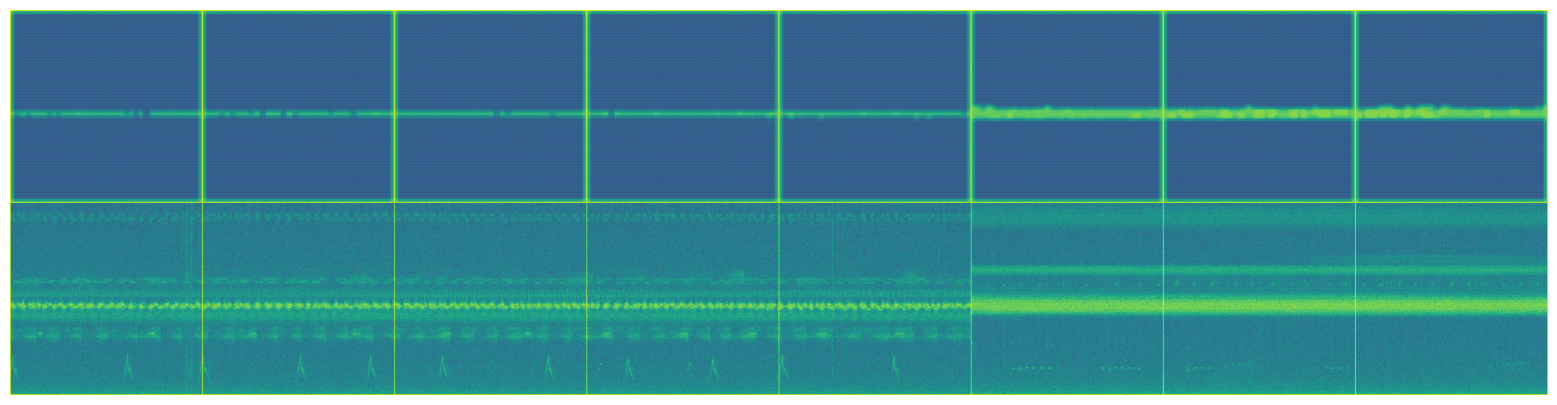

inputs:torch.Size([100, 1, 515, 515])


OutOfMemoryError: CUDA out of memory. Tried to allocate 400.00 MiB (GPU 0; 15.74 GiB total capacity; 8.60 GiB already allocated; 198.56 MiB free; 9.46 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [5]:
Training = TrainModel(model)
model, logs, run_name = Training.fordward(training_loader, test_loader, config)
time = datetime.datetime.now()
torch.save(model.state_dict(),f'temporal_zamuro/models/model_{run_name}_month_{time.month}_final.pth')
torch.save(config,f'temporal_zamuro/configs/config_{run_name}_day_{time.day}_hour_{time.hour}_final.pth')
#np.savetxt("corrupted_files.csv", logs, delimiter=",")

torch.cuda.memory_summary(device=None, abbreviated=False)


In [ ]:
# wandb.finish()
model.load_state_dict(torch.load(f'Models/Best_Model_Embedding_256_VQ_audio_length 12_win_length 1028_batch_size 8__5.pkl', map_location=torch.device('cpu')))

In [ ]:
root_path = '/content/drive/Shareddrives/ConservacionBiologicaIA/Datos/Porce_2019'


dataset = SoundscapeData(root_path=root_path, audio_length=12, ext='WAV', win_length=config["win_length"])
dataset_train, dataset_test = random_split(dataset,
                                          [round(len(dataset)*0.10), len(dataset) - round(len(dataset)*0.10)], 
                                           generator=torch.Generator().manual_seed(1024))

training_loader = DataLoader(dataset_train, batch_size=config["batch_size"], shuffle = False)
test_loader = DataLoader(dataset_test, batch_size=config["batch_size"])
iterator = iter(test_loader)

In [ ]:
spec, record, _ = next(iter(test_loader))

In [ ]:
spec_2 = audio_transform.Spectrogram(n_fft=1028, win_length=1028, window_fn=torch.hamming_window,power=2)(record)

In [ ]:
a = reconstruction.permute(1,0,2,3)
b = a.squeeze(dim=0)
b.shape

In [ ]:
b = b.type(torch.complex64).to("cpu")
wav = audio_transform.InverseSpectrogram(n_fft=1028, win_length=1028, hop_length=514)(b)

In [ ]:
Test = TestModel(model, iterator, 8)
originals, reconstruction, wav_ori, wav_recons, error = Test.run(wave_plot=True)
a = Test.waveform_generator(originals)
b = Test.waveform_generator(reconstruction)
waves = [a,b]
Test.plot_psd(waves)

In [ ]:
import torchaudio.transforms as audio_transform
reconstruction = reconstruction.cdouble()
reconstruction = reconstruction.to("cpu")
originals = originals.cdouble()
originals = originals.to("cpu")
transformation = audio_transform.InverseSpectrogram(n_fft=1025, win_length = 1025)
waveform = transformation(reconstruction)
waveform_original = transformation(originals)
waveform = waveform.cpu().detach().numpy()
waveform_original = waveform_original.cpu().detach().numpy()

In [ ]:
diff = waveform[0] - waveform_original[0]
diff = diff**2
plt.psd(waveform_original)
plt.psd(waveform)
#plt.psd(diff[0])
plt.show()